<center><img src="Fig/UGA.png" width="30%" height="30%"></center>
<center><h3>Master of Science in Industrial and Applied Mathematics (MSIAM)  - 1st year</h3></center>
<hr>
<center><h1>Numerical Optimization</h1></center>
<center><h2>Lab 8: Variance-Reduced Stochastic Gradient</h2></center>

---

### Instructions for the lab

Please, read carefully and follow these simple guidelines describing what and how you should send your production. 
- you have two ways to work:
    1. **in this notebook**: write your python code and comments in cells of this notebook, and hand this notebook;
    2. **no wotebook, just python**: create and work with your own `.py` file write your comments in a text / mardown / pdf file, and hand them both.
- Once you are done, you may
    1. compress all relevant files into a compressed archive (`.zip` or `.tar.gz`), named as: `LASTNAME1_Firstname1_LASTNAME2_Firstname2_LASTNAME3_Firstname3.zip`;
    2. send this archive be mail to `gilles.bareilles@univ-grenoble-alpes.fr`, with object `[NumOpt] Lab 8 report`. Make sure you mention your names in the body of the mail as well;
- I need to be able to run your notebook / python files on my machine **without looking at your code**. Make sure that:
    1. you send me all necessary files;
    2. if working with python files, indicate in your report what command I should run.

You may work alone or in groups of 2 to 3 persons.

> **Task 0**: Please enter the full names of all members in the next cell.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import logistic_regression_student as pb
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

# Logistic Regression Problem
 
 
 
### Machine Learning as an Optimization problem
 
We have some *data*  $\mathcal{D}$ consisting of $m$ *examples* $\{d_i\}$; each example consisting of a *feature* vector $a_i\in\mathbb{R}^d$ and an *observation* $b_i\in \mathcal{O}$: $\mathcal{D} = \{[a_i,b_i]\}_{i=1..m}$. In this lab, we will consider the <a href="http://archive.ics.uci.edu/ml/datasets/Student+Performance">student performance</a> dataset.
 
 
The goal of *supervised learning* is to construct a predictor for the observations when given feature vectors.
 
 
 A popular approach is based on *linear models* which are based on finding a *parameter* $x$ such that the real number $\langle a_i , x \rangle$ is used to predict the value of the observation through a *predictor function* $g:\mathbb{R}\to \mathcal{O}$: $g(\langle a_i , x \rangle)$ is the predicted value from $a_i$.
 
 
 In order to find such a parameter, we use the available data and a *loss* $\ell$ that penalizes the error made between the predicted $g(\langle a_i , x \rangle)$ and observed $b_i$ values. For each example $i$, the corresponding error function for a parameter $x$ is $f_i(x) =   \ell( g(\langle a_i , x \rangle) ; b_i )$. Using the whole data, the parameter that minimizes the total error is the solution of the minimization problem
 $$ \min_{x\in\mathbb{R}^d}  \frac{1}{m} \sum_{i=1}^m f_i(x) = \frac{1}{m} \sum_{i=1}^m  \ell( g(\langle a_i , x \rangle) ; b_i ). $$
 
 
 
### Regularized Problem 
 
In this lab, we will consider an $\ell_1$ regularization to promote sparsity of the iterates. A sparse final solution would select the most important features. The new function (below) is non-smooth but it has a smooth part, $f$; and a non-smooth part, $g$, that we will treat with proximal operations.
 
 \begin{align*}
     \min_{x\in\mathbb{R}^d } F(x) := \underbrace{ \frac{1}{m} \sum_{i=1}^m \overbrace{ \left( \log( 1+\exp(-b_i \langle a_i,x \rangle) ) + \frac{\lambda_2}{2} \|x\|_2^2 \right) }^{f_i(x)} }_{f(x)} + \underbrace{\lambda_1 \|x\|_1 }_{g(x)}.
 \end{align*}

# Recall of the proximal gradient algorithm

Below is an implementation of the proximal gradient algorithm.

In [3]:
def proximal_gradient_algorithm(F , f_grad , g_prox , x0 , step , PREC , ITE_MAX , PRINT ):
    x = np.copy(x0)
    x_tab = np.copy(x)
    if PRINT:
        print("------------------------------------\n Proximal gradient algorithm\n------------------------------------\nSTART    -- stepsize = {:0}".format(step))
    t_s =  timeit.default_timer()

    for k in range(ITE_MAX):
        g = f_grad(x)
        x = g_prox(x - step*g , step)

        x_tab = np.vstack((x_tab,x))

    t_e =  timeit.default_timer()
    if PRINT:
        print("FINISHED -- {:d} iterations / {:.6f}s -- final value: {:f}".format(k,t_e-t_s,F(x)))
    return x, x_tab

In [4]:
#### Parameter we give our algorithm
PREC    = 1e-5                     # Sought precision
ITE_MAX = 1000                     # Max number of iterations
x0      = np.zeros(pb.n)           # Initial point
step    = 1.0/pb.L

##### gradient algorithm
x,x_tab = proximal_gradient_algorithm(pb.F, pb.f_grad , pb.g_prox, x0, step, PREC, ITE_MAX , True)

------------------------------------
 Proximal gradient algorithm
------------------------------------
START    -- stepsize = 0.030334772813507393
FINISHED -- 999 iterations / 2.342357s -- final value: 0.438712


### Decrease of the algorithm.

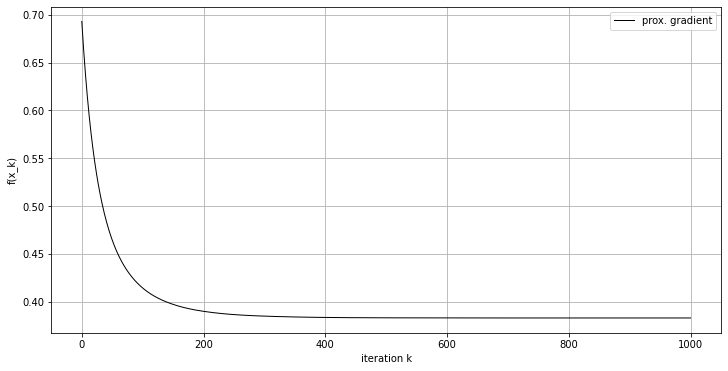

In [10]:
xs = range(x_tab.shape[0])
ys = [ pb.f(x_tab[ind]) for ind in xs ]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(xs, ys, linewidth=1.0, linestyle='-', label='prox. gradient', color='black')
ax.set(xlabel='iteration k', ylabel='f(x_k)')
ax.legend(); ax.grid()

### Support of the vector $x_k$ 

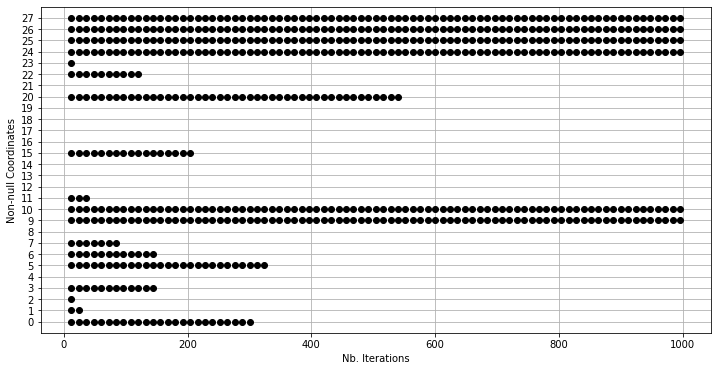

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in np.arange(0,x_tab.shape[0],int(x_tab.shape[0]/80)):
    for j in range(pb.n):
        if np.abs(x_tab[i, j])>1e-14:
            ax.plot(i, j,'ko')

ax.set(ylabel='Non-null Coordinates', xlabel='Nb. Iterations', ylim=(-1,pb.d+1), yticks=np.arange(0,pb.d+1))
ax.grid()

---
# Stochastic methods

## Obtaining a stochastic approximation of the gradient

In the following, instead of considering $f$ as a whole, we will use its structure 
$$ f(x) := \frac{1}{m}\sum_{i=1}^m f_i(x)$$

> **Task 1**: Implement the oracle corresponfing to evaluating $f_i$ and $\nabla f_i$, the function related to one example, in `logistic_regression_student.py`.

> **Task 2**: Compare the evaluation times of $f$, $\nabla f$, $f_i$, $\nabla f_i$. What do you notice?

Note your comments here.

##  Stochastic gradient

We recall here the stochastic gradient algorithm. It is the basic scheme for dealing with problems with this sum structure. Recall that each iteration $k$ writes as:
    
1. Pick $i_k$ uniformly in $\{1, ..., m\};

2. $x_{k+1} = \mathbf{prox}_{\gamma_k g}\left( x_k - \gamma_k \nabla f_i(x_k) \right) $;

where $\gamma_k$ behaves as $1/k$.

In [7]:
def stochastic_gradient(F, f_grad_ex , g_prox , x0 , PREC , ITE_MAX , PRINT ):
    x = np.copy(x0)
    x_tab = np.copy(x)
    if PRINT:
        print("------------------------------------\n Stochastic gradient algorithm\n------------------------------------")
        print("START    -- initial value: {:f}".format(F(x)))
    t_s =  timeit.default_timer()

    for k in range(ITE_MAX):
        step = 1/(1+k)
        i = np.random.randint(pb.m)
        gᵢ = f_grad_ex(x, i)
        x = g_prox(x - step*gᵢ , step)

        x_tab = np.vstack((x_tab,x))

    t_e =  timeit.default_timer()
    if PRINT:
        print("FINISHED -- {:d} iterations / {:.6f}s -- final value: {:f}".format(k,t_e-t_s,F(x)))
    return x, x_tab

In [8]:
x,x_tab_sg = stochastic_gradient(pb.F , pb.f_grad_ex, pb.g_prox, x0, PREC, 100, True)

------------------------------------
 Stochastic gradient algorithm
------------------------------------
START    -- initial value: 0.693147
FINISHED -- 99 iterations / 0.005154s -- final value: 0.693147


## Variance reduced stochastic gradient

The poor performance of the stochastic gradient algorithm is notably due to the variance of the gradients. In order to overcome it, *variance reduced* algorithms have been proposed.

We will consider here the popular **SAGA** algorithm  (SAGA: A fast incremental gradient method with support for non-strongly convex composite objectives - A Defazio, F Bach, S Lacoste-Julien, NIPS 2014. ) 

> **Task 3**: Implement the SAGA algorithm from the paper ( http://papers.nips.cc/paper/5258-saga-a-fast-incremental-gradient-method-with-support-for-non-strongly-convex-composite-objectives ).

### Decrease and sparsity

> **Task 4**: Investigate the decrease of the stochastic gradient algorithm, and the sparsity of the iterates.

Note your comments here.

### Implementation choices and validation

> **Task 5**: Explain in the next cell the choices you made in implementing the algorithm and how you checked that your implementation is correct.

Note your comments here.

### Algorithms comparison

> **Task 6**: Compare the efficiency of SAGA with stochastic gradient and proximal gradient descent. In particular, explain how you compare the algorithms.

Note your comments here.

### Behavior on convex vs strongly convex problems

> **Task 7**: Explore the behavior of the 3 algorihtms on a (merely) convex problem and a strongly convex problem. What rates of convergence can you conjecture? Can you support your conjecture with some numerics?

Note that you may tune the values of $\lambda_1$ and $\lambda_2$ of the problem as follows:
```python
#### Parameters defining our problem
λ_1 = 0.1
λ_2 = 0.03
L = 0.25*max(np.linalg.norm(pb.A,2,axis=1))**2 + λ_2  # Lipschitz constant of ∇f

F = lambda x: pb.F(x, lambda1=λ_1, lambda2=λ_2)
f_grad = lambda x: pb.f_grad(x, lambda2=λ_2)
g_prox = lambda x, step: pb.g_prox(x, step, lambda1 = λ_1)
```
You may then pass directly the functions `F`, `f_grad`, `g_prox` to your algorithm, and use the same pattern to adapt `f_grad_ex`. Notice as well that the Lipschitz constant for this problem is computed, and may be used to set the stepsize of the algorithms.

Note your comments here.

### Additional comments

Note your comments here